In [1]:
import pandas as pd
from keras import Sequential
from keras import layers
#import sklearn
#import eli5
#from eli5.sklearn import PermutationImportance
import shap
import numpy as np
#from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1️⃣ Load dataset
df_train = pd.read_csv("data/features/session_based_trainset.csv")
print("Training dataset shape:", df_train.shape)
df_test = pd.read_csv("data/features/session_based_testset.csv")
print("Testing dataset shape:", df_test.shape)

Training dataset shape: (488524, 280)
Testing dataset shape: (122132, 280)


In [3]:
# 2️⃣ Use the correct label column
label_col = "label"
print("Unique values in label:", df_train[label_col].unique())
print("Unique values in label:", df_test[label_col].unique()) #is this flip-flop the source of a problem? Don't think so

Unique values in label: [0 1]
Unique values in label: [1 0]


In [4]:
# 3️⃣ Prepare features and target
y_raw = df_train[label_col]
X = df_train.drop(columns=[label_col]).fillna(0)

ytest_raw = df_test[label_col]
X_test = df_test.drop(columns=[label_col]).fillna(0) #new x test

In [5]:
# 4️⃣ Convert label text/numbers → binary
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1

y = y_raw.apply(map_label)
y_test = ytest_raw.apply(map_label) #new y test
print("\nBinary label distribution in train set (0=Benign, 1=Malicious):\n", y.value_counts())
print("\nBinary label distribution in test set (0=Benign, 1=Malicious):\n", y_test.value_counts())


Binary label distribution in train set (0=Benign, 1=Malicious):
 label
1    245470
0    243054
Name: count, dtype: int64

Binary label distribution in test set (0=Benign, 1=Malicious):
 label
0    61273
1    60859
Name: count, dtype: int64


In [6]:
# 5️⃣ Train/test split
'''X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nX Train:", X_train.shape, "X Test:", X_test.shape)'''

#no need to perform splits since there is an entire separate testing data set
X_train = X
y_train = y
print(X_train.shape)

(488524, 279)


In [7]:
# 6️⃣ Train 1D CNN model
cnn_model = Sequential()
cnn_model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(279, 1)))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Conv1D(64, 3, activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.GlobalAveragePooling1D())
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32)

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.5654 - loss: 46695438090240.0000
Epoch 2/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.7186 - loss: 856104192.0000
Epoch 3/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.7821 - loss: 546209792.0000
Epoch 4/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.7053 - loss: 20754994.0000
Epoch 5/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.7379 - loss: 7043373056.0000
Epoch 6/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.7379 - loss: 51854647296.0000
Epoch 7/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.7945 - loss: 110137584.0000
Epoch 8/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.8083 - loss: 35263672320.0000
Epoch 9/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.8495 - loss: 0.3853
Epoch 10/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.8709 - loss: 0.3499


In [8]:
# 7️⃣ Evaluate model
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

3817/3817 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8841 - loss: 0.3005
Test Loss: 0.3001
Test Accuracy: 0.8835


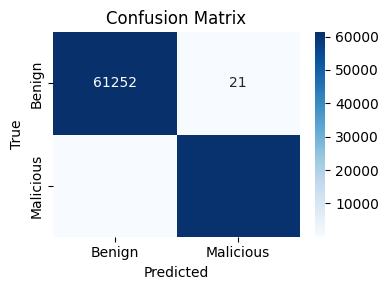

In [28]:
# 8️⃣ Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [11]:
# 9️⃣ Feature Importance
X_train_subset = np.random.rand(100, 279,1)
explainer = shap.DeepExplainer(cnn_model, X_train_subset)
shap_values = explainer.shap_values(X_train_subset)
mean_abs_shap_values = np.mean(np.abs(shap_values[0]), axis=0)
#perm_importance = PermutationImportance(cnn_model, scoring='accuracy', random_state=42).fit(X_test, y_test)
#perm_import = permutation_importance(cnn_model, X_test, y_test, scoring='accuracy', random_state=1)
#eli5.show_weights(perm_importance, feature_names=your_feature_names_list)
#feature_importances = perm_import.feature_importances_
#imp = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
'''plt.figure(figsize=(8,5))
imp.head(15).plot(kind="barh", title="Top 15 Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()'''

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 279, 1))']
  warnings.warn(msg)


'plt.figure(figsize=(8,5))\nimp.head(15).plot(kind="barh", title="Top 15 Important Features")\nplt.gca().invert_yaxis()\nplt.tight_layout()\nplt.show()'

In [ ]:
# 🔟 Save 
joblib.dump(cnn_model, "report/mini_cnn_session_model.joblib")
imp.to_csv("report/mini_cnn_feature_importance.csv", index=True)
print("\nModel and feature importances saved in report/")


Model and feature importances saved in report/
